In [6]:
import os
import json

import fiftyone as fo
import fiftyone.zoo as foz

import pandas as pd
from sklearn.model_selection import train_test_split

#from loguru import logger

## Download COCO-2017 dataset

**Classes:**
  * person
  * car
  * bicycle
  * motorcycle
  * bus
  * truck


In [2]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["train", "validation"],
    classes=["person", "car", "bicycle", "motorcycle", "bus", "truck"],
    max_samples=2000,
    only_matching=True,
)


session = fo.launch_app(dataset, auto=False)
session

Found annotations at '/Users/mlstudio/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Found annotations at '/Users/mlstudio/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-train-validation-2000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instruc

Dataset:          coco-2017-train-validation-2000
Media type:       image
Num samples:      4000
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [3]:
sample = dataset.first()

sample

<Sample: {
    'id': '66f9c728456603f2016f66f2',
    'media_type': 'image',
    'filepath': '/Users/mlstudio/fiftyone/coco-2017/train/data/000000001315.jpg',
    'tags': ['train'],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 480,
        'height': 640,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '66f9c728456603f2016f66e7',
                'attributes': {},
                'tags': [],
                'label': 'bicycle',
                'bounding_box': [
                    0.9574374999999999,
                    0.55921875,
                    0.042562499999999996,
                    0.10275000000000001,
                ],
                'mask': None,
                'confidence': None,
                'index': None,
                'supercategory': 'vehicle',
                'iscrowd': 0,
            }>,
            <Detect

## Preparing annotations for Faster-RCNN

 * using custom json format

In [8]:
annot_dir = "data/annotations"
os.makedirs(annot_dir, exist_ok=True)

list_samples = []

for sample in dataset:
    if sample["ground_truth.detections"] is None:
        continue
    filename = os.path.basename(sample["filepath"])

    img_width = sample["metadata"]["width"]
    img_height = sample["metadata"]["height"]
    labels = set([det["label"] for det in sample["ground_truth.detections"]])
    annots = []
    for det in sample["ground_truth.detections"]:
        label = det["label"]
        x, y, w, h = det["bounding_box"]
        x, y = int(x * img_width), int(y * img_height)
        w, h = int(w * img_width), int(h * img_height)
        annots.append({
            "label": label,
            "x": x, "y": y,
            "width": w, "height": h
        })

    label_path = os.path.join(annot_dir, filename.replace("jpg", "json"))
    with open(label_path, "w") as f:
        json.dump(annots, f)

    list_samples.append({
        "imagepath": sample["filepath"],
        "labelpath": label_path,
        "tag": sample["tags"][0]
    })
        
    #break

df = pd.DataFrame(list_samples)
df.head()

,imagepath,labelpath,tag
0,/Users/mlstudio/fiftyone/coco-2017/train/data/...,data/annotations/000000001315.json,train
1,/Users/mlstudio/fiftyone/coco-2017/train/data/...,data/annotations/000000022741.json,train
2,/Users/mlstudio/fiftyone/coco-2017/train/data/...,data/annotations/000000043202.json,train
3,/Users/mlstudio/fiftyone/coco-2017/train/data/...,data/annotations/000000061181.json,train
4,/Users/mlstudio/fiftyone/coco-2017/train/data/...,data/annotations/000000095850.json,train


<Axes: title={'center': 'Number of samples per split'}, xlabel='tag'>

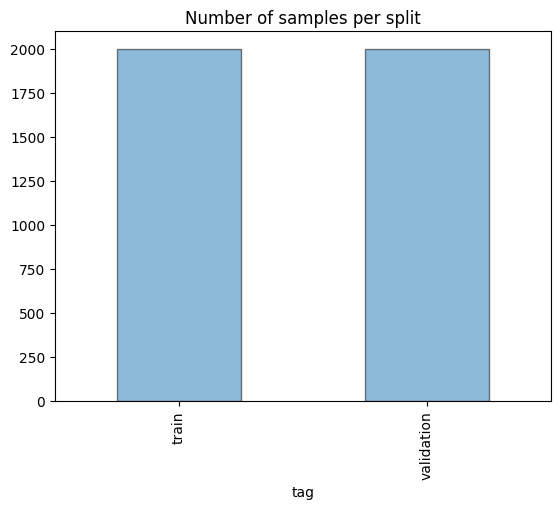

In [9]:
# bar plot of train/test/validation split
df["tag"].value_counts().plot(
    kind="bar", alpha=0.5, edgecolor="black",
    title="Number of samples per split"
)

In [11]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of Train samples: {len(df[df['tag'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['tag'] == 'validation'])}")


2024-09-30 22:37:07.282 | INFO     | __main__:<module>:1 - Number of samples: 4000
2024-09-30 22:37:07.287 | INFO     | __main__:<module>:2 - Number of Train samples: 2000
2024-09-30 22:37:07.289 | INFO     | __main__:<module>:3 - Number of Validation samples: 2000


In [12]:
# use current validation set as test set
df_test = df[df["tag"] == "validation"].reset_index(drop=True)
df_test["tag"] = "test"

# split train -> train/val (80%/20%)
df_train = df[df["tag"] == "train"].reset_index(drop=True)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
df_train["tag"] = "train"
df_val["tag"] = "val"

# concatenate
df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

df.to_csv("data/data.csv", index=False)

In [10]:
dataset.delete()

In [13]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of Train samples: {len(df[df['tag'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['tag'] == 'val'])}")
logger.info(f"Number of Test samples: {len(df[df['tag'] == 'test'])}")


2024-09-30 22:37:58.240 | INFO     | __main__:<module>:1 - Number of samples: 4000
2024-09-30 22:37:58.242 | INFO     | __main__:<module>:2 - Number of Train samples: 1600
2024-09-30 22:37:58.243 | INFO     | __main__:<module>:3 - Number of Validation samples: 400
2024-09-30 22:37:58.244 | INFO     | __main__:<module>:4 - Number of Test samples: 2000
